## TODO ##
- dodać lime
- wydzielić sensowne fragmenty kodu do plików pythonowych
- odpalić kod na innych datasetach
- odpalić więcej random-searchów
- dodać readme
- odpalić na obciętym datasecie
- wrzucić rezultaty do README.md


In [1]:
import glob, os
import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from collections import Counter

from sklearn.svm import SVR, SVC
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn import  metrics

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping, defaultdict


## Load datasets ##

In [65]:
from types import SimpleNamespace 
from typing import Tuple


class Dataset:
    def __init__(self, path):
        dataset = dict(np.load(path, allow_pickle=True))
        self.X = dataset.pop('X')
        self.y = dataset.pop('y')
        self.meta = dataset.pop('meta')[()]
        
        assert len(dataset) == 0
        
        self.y_binary = np.where(self.y == None, 0, 1)
    
    def normalize(self, mean=None, std=None):
        # TODO: czy powinniśmy normalizować per współrzędna czy globalnie?
        if mean is None:
            mean = np.mean(self.X, axis=0)
            
        if std is None:
            std = np.std(self.X, axis=0, ddof=1)
            
        print(mean.shape, std.shape)
        
        self.X = (self.X - mean) / std
        
        return mean, std
    
    def sample(self, n, balanced=False, with_idx=False) -> Tuple[np.ndarray, np.ndarray]:
        """
        Choice `n` random samples from dataset.
        @param n: number of random samples to choose
        @param balanced: if True number of samples for each class will be aprox. equal.
        """
        assert len(self.y_binary.shape) == 1
        
        if balanced:
            counts = Counter(self.y_binary)
            class_count = len(counts)
            
            # NOTE: https://stackoverflow.com/questions/35215161/most-efficient-way-to-map-function-over-numpy-array/35216364
            probs = np.array([1.0 / (class_count * counts[x]) for x in self.y_binary])
        else:
            probs = None
            
        idx = np.random.choice(self.y.size, size=n, p=probs)
        if with_idx:
            return idx, self.X[idx], self.y_binary[idx]
        return self.X[idx], self.y_binary[idx]
    
    def frame_to_time(self, frame: int) -> float:
        return librosa.core.frames_to_time(
            frame,
            sr=self.meta['sampling_rate'],
            hop_length=self.meta['hop_length'],
            n_fft=self.meta['n_fft']
        )    

    
# train_data = load_dataset('ch1-2018-11-20_10-31-42_0000014.wav.npz')
train_data = Dataset('ch1-2018-11-20_10-29-02_0000012.wav.npz')
test_data = Dataset('ch1-2018-11-20_10-26-36_0000010.wav.npz')

In [10]:
type_numbers = Counter(train_data.y)

# for usv_type in USV_TYPES:
#     size = np.argwhere(y == usv_type).reshape(-1).size
#     print(usv_type, size)
#     type_nubers += [size]

# mean_sample = np.int64(np.mean(type_nubers));
# print("MEAN", mean_sample)

for key, count in type_numbers.most_common():
    print(key, count)

mean = sum(type_numbers.values()) / len(type_numbers)
print(f"MEAN: {mean:.2f}")

None 189860
ST 12243
TR 10877
FM 8514
FL 7060
CMP 4227
RP 1028
SH 469
IU 107
MEAN: 26042.78


# SVM classification #

### Correlation matrix ###

(257, 257)


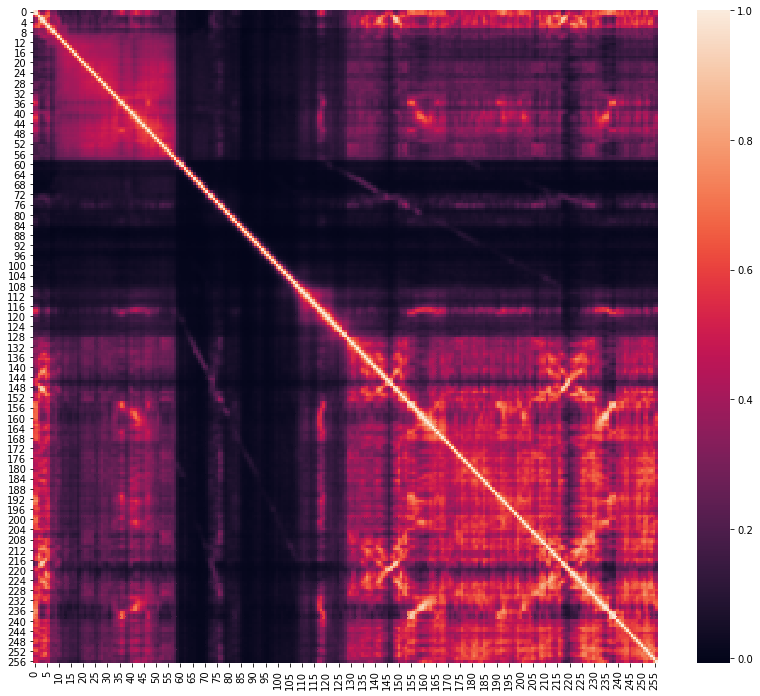

In [77]:
corr = np.corrcoef(train_data.X.T)
print(corr.shape)

plt.figure(figsize=(14,12))
sns.heatmap(corr)
# print(cov.diag())
# i = np.arange(257)


### Normalization for SVM ###

In [42]:
print(Counter(train_data.y_binary))
print(Counter(test_data.y_binary))

Counter({0: 189860, 1: 44525})
Counter({0: 209553, 1: 24832})


In [20]:
mean, std = train_data.normalize()
print(np.mean(train_data.X), np.std(train_data.X, ddof=1))

test_data.normalize(mean, std)
print(np.mean(test_data.X), np.std(test_data.X, ddof=1))

(257,) (257,)
3.473007e-07 1.000209
(257,) (257,)
-0.015875459 0.9597498


In [21]:
N_samples = 5000

# def get_sample(is_none, sample_size, X, y):
#     idx = np.argwhere((y == None) == is_none).reshape(-1)
#     randint_array = np.random.randint(idx.size, size=sample_size)
#     sample_idx = idx[randint_array]
#     return (X[sample_idx], y[sample_idx])

# X1, y1 = get_sample(True, N_samples, train_data.X, train_data.y)
# X2, y2 = get_sample(False, N_samples, train_data.X, train_data.y)

# X = np.concatenate((X1, X2))
# y = np.concatenate((y1, y2))

# y_binary = np.where(y == None, 0, 1)

# print(X.shape, y_binary.shape)
X, y = train_data.sample(N_samples, balanced=True)
print(X.shape)
print(Counter(y))

(5000, 257)
Counter({1: 2527, 0: 2473})


In [22]:
def evaluate_model(model, dataset, n=10000, balanced=False):
    idx, X, y_true = dataset.sample(n, balanced=balanced, with_idx=True)
    
    y_pred = model.predict(X)

    print(confusion_matrix(y_true, y_pred))

    print('accuracy:', accuracy_score(y_true, y_pred))
    precision, recall, fscore, support = precision_recall_fscore_support(y_true, y_pred, average='macro')

    print('precision:', precision)
    print('recall:', recall)
    print('fscore:', fscore)
    c = Counter(y_true)
    print('support:', c)
    
    return idx, y_pred, y_true


# model = SVC(kernel='rbf', gamma='auto') # 0.9021
# model = SVC(kernel='poly', degree=3, gamma='auto') # 0.93335
# model = SVC(kernel='poly', degree=2, gamma='auto') # 0.9414
model = SVC(kernel='poly', degree=1, gamma='auto') # 0.9424
# model = SVC(kernel='linear', degree=1, gamma='auto') # 0.9402
# model = SVC(kernel='sigmoid', gamma='auto')

# Train
# idx_pos = np.random.choice(np.argwhere(train_data.y_binary == 1).reshape(-1), 2000)
# idx_neg = np.random.choice(np.argwhere(train_data.y_binary == 0).reshape(-1), 3000)

# idx = np.concatenate((idx_pos, idx_neg))
# np.random.shuffle(idx)

c = Counter(y)
print(c)
print('Baselines:')
print('weighted random accuracy:', sum(i*i for i in c.values()) / sum(c.values())**2)
print('max random accuracy:', max(c.values()) / sum(c.values()))
print()


model.fit(X, y)
print('Done')

# Evaluation
print('Trainset:')
evaluate_model(model, train_data)

print()
print('TestSet:')
evaluate_model(model, test_data)
evaluate_model(model, test_data, balanced=True)

Counter({1: 2527, 0: 2473})
Baselines:
weighted random accuracy: 0.50005832
max random accuracy: 0.5054

Done
Trainset:
[[7954  130]
 [ 732 1184]]
accuracy: 0.9138
precision: 0.9083959526886107
recall: 0.8009364615173249
fscore: 0.840862811559046
support: Counter({0: 8084, 1: 1916})

TestSet:
[[8822  103]
 [ 504  571]]
accuracy: 0.9393
precision: 0.8965692734838501
recall: 0.7598110872255879
fscore: 0.8098430440726496
support: Counter({0: 8925, 1: 1075})
[[4933   64]
 [2357 2646]]
accuracy: 0.7579
precision: 0.8265320739627149
recall: 0.7580374928934974
fscore: 0.7445384165313464
support: Counter({1: 5003, 0: 4997})


(array([128219,  36366, 102339, ...,  73677, 195091,  23178]),
 array([1, 0, 0, ..., 0, 0, 0]),
 array([1, 1, 0, ..., 1, 0, 1]))

# Grid Search Cross Validation #

In [5]:
#WARNING: brudne haxy
import signal, time, sys, os
import multiprocessing
import random


class FitTimeoutError(Exception):
    pass


def timeout(clf, timeout=5.0):
    """Estimators' decorator for timouting fitting process."""
    def fit(self, *args, _timeout=timeout, **kwargs):
        pool = multiprocessing.pool.ThreadPool(1)
        async_result = pool.apply_async(clf.fit, (self, *args), kwargs)
        try:
            return async_result.get(_timeout)
        except multiprocessing.TimeoutError as e:
            raise FitTimeoutError(f"fit timeout after {timeout:.2f}s") from e
            
    name = f"{clf.__name__}_with_timeout"
    cls = type(name, (clf,), dict(fit=fit))   
    
    setattr(sys.modules['abc'], name, cls)
    
    return cls

In [14]:
from sklearn.model_selection import RandomizedSearchCV

distributions = dict(
    kernel=['linear', 'rbf', 'poly'],
    degree=[1, 2, 3],
    C=[0.01, 0.1, 0.5, 1, 2, 5, 10, 100],
    gamma=['auto', 100, 10, 1, 0.1, 10, 0.01, 0.001]
)

clf = RandomizedSearchCV(
    timeout(SVC, timeout=120)(), 
    distributions,
    random_state=2,
    verbose=2,
    n_jobs=3,
    cv=5,
    scoring='f1',
    n_iter=60,
    error_score=-np.inf,
    refit=False,
    return_train_score=True
)

print(clf)

clf.fit(X, y)

RandomizedSearchCV(cv=5, error_score=-inf,
          estimator=SVC_with_timeout(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
         decision_function_shape='ovr', degree=3, gamma='auto',
         kernel='rbf', max_iter=-1, probability=False, random_state=None,
         shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=60, n_jobs=3,
          param_distributions={'kernel': ['linear', 'rbf', 'poly'], 'degree': [1, 2, 3], 'C': [0.01, 0.1, 0.5, 1, 2, 5, 10, 100], 'gamma': ['auto', 100, 10, 1, 0.1, 10, 0.01, 0.001]},
          pre_dispatch='2*n_jobs', random_state=2, refit=False,
          return_train_score=True, scoring='f1', verbose=2)
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] kernel=linear, gamma=0.001, degree=1, C=2 .......................
[CV] kernel=linear, gamma=0.001, degree=1, C=2 .......................
[CV] kernel=linear, gamma=0.001, degree=1, C=2 .......................
[CV] ........ kernel=linear, gamma=0

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  2.4min


[CV] ........... kernel=poly, gamma=auto, degree=2, C=5, total=   5.4s
[CV] kernel=poly, gamma=auto, degree=2, C=5 ..........................
[CV] ........... kernel=poly, gamma=auto, degree=2, C=5, total=   5.7s
[CV] kernel=poly, gamma=auto, degree=2, C=5 ..........................
[CV] ........... kernel=poly, gamma=auto, degree=2, C=5, total=   5.7s
[CV] kernel=poly, gamma=0.01, degree=2, C=0.5 ........................
[CV] ........... kernel=poly, gamma=auto, degree=2, C=5, total=   5.0s
[CV] kernel=poly, gamma=0.01, degree=2, C=0.5 ........................
[CV] ........... kernel=poly, gamma=auto, degree=2, C=5, total=   5.4s
[CV] kernel=poly, gamma=0.01, degree=2, C=0.5 ........................
[CV] ......... kernel=poly, gamma=0.01, degree=2, C=0.5, total=   5.3s
[CV] kernel=poly, gamma=0.01, degree=2, C=0.5 ........................
[CV] ......... kernel=poly, gamma=0.01, degree=2, C=0.5, total=   5.8s
[CV] kernel=poly, gamma=0.01, degree=2, C=0.5 ........................
[CV] .

/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=10, degree=1, C=100, total= 2.0min
[CV] kernel=linear, gamma=10, degree=1, C=100 ........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=10, degree=1, C=100, total= 2.0min
[CV] kernel=linear, gamma=10, degree=1, C=100 ........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=10, degree=1, C=100, total= 2.0min
[CV] kernel=poly, gamma=1, degree=3, C=0.1 ...........................
[CV] ............ kernel=poly, gamma=1, degree=3, C=0.1, total=  12.5s
[CV] kernel=poly, gamma=1, degree=3, C=0.1 ...........................
[CV] ............ kernel=poly, gamma=1, degree=3, C=0.1, total=  19.1s
[CV] kernel=poly, gamma=1, degree=3, C=0.1 ...........................
[CV] ............ kernel=poly, gamma=1, degree=3, C=0.1, total=  18.5s
[CV] kernel=poly, gamma=1, degree=3, C=0.1 ...........................
[CV] ............ kernel=poly, gamma=1, degree=3, C=0.1, total=  21.2s
[CV] kernel=poly, gamma=1, degree=3, C=0.1 ...........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=10, degree=1, C=100, total= 2.0min
[CV] kernel=poly, gamma=100, degree=1, C=0.1 .........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=10, degree=1, C=100, total= 2.0min
[CV] kernel=poly, gamma=100, degree=1, C=0.1 .........................
[CV] ............ kernel=poly, gamma=1, degree=3, C=0.1, total=  20.4s
[CV] kernel=poly, gamma=100, degree=1, C=0.1 .........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] .......... kernel=poly, gamma=100, degree=1, C=0.1, total= 2.0min
[CV] kernel=poly, gamma=100, degree=1, C=0.1 .........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] .......... kernel=poly, gamma=100, degree=1, C=0.1, total= 2.0min
[CV] kernel=poly, gamma=100, degree=1, C=0.1 .........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] .......... kernel=poly, gamma=100, degree=1, C=0.1, total= 2.0min
[CV] kernel=rbf, gamma=10, degree=3, C=1 .............................
[CV] .............. kernel=rbf, gamma=10, degree=3, C=1, total=  38.9s
[CV] kernel=rbf, gamma=10, degree=3, C=1 .............................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] .......... kernel=poly, gamma=100, degree=1, C=0.1, total= 2.0min
[CV] kernel=rbf, gamma=10, degree=3, C=1 .............................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] .......... kernel=poly, gamma=100, degree=1, C=0.1, total= 2.0min
[CV] kernel=rbf, gamma=10, degree=3, C=1 .............................
[CV] .............. kernel=rbf, gamma=10, degree=3, C=1, total=  23.6s
[CV] kernel=rbf, gamma=10, degree=3, C=1 .............................
[CV] .............. kernel=rbf, gamma=10, degree=3, C=1, total=  22.9s
[CV] kernel=rbf, gamma=10, degree=2, C=5 .............................
[CV] .............. kernel=rbf, gamma=10, degree=3, C=1, total=  23.7s
[CV] kernel=rbf, gamma=10, degree=2, C=5 .............................
[CV] .............. kernel=rbf, gamma=10, degree=3, C=1, total=  22.9s
[CV] kernel=rbf, gamma=10, degree=2, C=5 .............................
[CV] .............. kernel=rbf, gamma=10, degree=2, C=5, total=  33.8s
[CV] kernel=rbf, gamma=10, degree=2, C=5 .............................
[CV] .............. kernel=rbf, gamma=10, degree=2, C=5, total=  35.4s
[CV] kernel=rbf, gamma=10, degree=2, C=5 .............................
[CV] .

/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] .......... kernel=poly, gamma=0.1, degree=1, C=100, total= 2.0min
[CV] kernel=poly, gamma=0.1, degree=1, C=100 .........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] .......... kernel=poly, gamma=0.1, degree=1, C=100, total= 2.0min
[CV] kernel=poly, gamma=0.1, degree=1, C=100 .........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] .......... kernel=poly, gamma=0.1, degree=1, C=100, total= 2.0min
[CV] kernel=linear, gamma=0.1, degree=3, C=0.01 ......................
[CV] ....... kernel=linear, gamma=0.1, degree=3, C=0.01, total=  13.4s
[CV] kernel=linear, gamma=0.1, degree=3, C=0.01 ......................
[CV] ....... kernel=linear, gamma=0.1, degree=3, C=0.01, total=  11.0s
[CV] kernel=linear, gamma=0.1, degree=3, C=0.01 ......................
[CV] ....... kernel=linear, gamma=0.1, degree=3, C=0.01, total=  10.1s
[CV] kernel=linear, gamma=0.1, degree=3, C=0.01 ......................
[CV] ....... kernel=linear, gamma=0.1, degree=3, C=0.01, total=   9.6s
[CV] kernel=linear, gamma=0.1, degree=3, C=0.01 ......................
[CV] ....... kernel=linear, gamma=0.1, degree=3, C=0.01, total=   9.0s
[CV] kernel=rbf, gamma=10, degree=3, C=10 ............................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] .......... kernel=poly, gamma=0.1, degree=1, C=100, total= 2.0min
[CV] kernel=rbf, gamma=10, degree=3, C=10 ............................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] .......... kernel=poly, gamma=0.1, degree=1, C=100, total= 2.0min
[CV] kernel=rbf, gamma=10, degree=3, C=10 ............................
[CV] ............. kernel=rbf, gamma=10, degree=3, C=10, total=  19.0s
[CV] kernel=rbf, gamma=10, degree=3, C=10 ............................
[CV] ............. kernel=rbf, gamma=10, degree=3, C=10, total=  22.7s
[CV] kernel=rbf, gamma=10, degree=3, C=10 ............................
[CV] ............. kernel=rbf, gamma=10, degree=3, C=10, total=  21.9s
[CV] kernel=rbf, gamma=10, degree=3, C=0.1 ...........................
[CV] ............. kernel=rbf, gamma=10, degree=3, C=10, total=  22.7s
[CV] kernel=rbf, gamma=10, degree=3, C=0.1 ...........................
[CV] ............. kernel=rbf, gamma=10, degree=3, C=10, total=  21.0s
[CV] kernel=rbf, gamma=10, degree=3, C=0.1 ...........................
[CV] ............ kernel=rbf, gamma=10, degree=3, C=0.1, total=  21.0s
[CV] kernel=rbf, gamma=10, degree=3, C=0.1 ...........................


[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 29.2min


[CV] ............ kernel=rbf, gamma=10, degree=3, C=0.1, total=  18.8s
[CV] kernel=rbf, gamma=10, degree=3, C=0.1 ...........................
[CV] ............ kernel=rbf, gamma=10, degree=3, C=0.1, total=  17.7s
[CV] kernel=poly, gamma=10, degree=3, C=0.5 ..........................
[CV] ............ kernel=rbf, gamma=10, degree=3, C=0.1, total=  18.0s
[CV] kernel=poly, gamma=10, degree=3, C=0.5 ..........................
[CV] ............ kernel=rbf, gamma=10, degree=3, C=0.1, total=  16.9s
[CV] kernel=poly, gamma=10, degree=3, C=0.5 ..........................
[CV] ........... kernel=poly, gamma=10, degree=3, C=0.5, total=  12.2s
[CV] kernel=poly, gamma=10, degree=3, C=0.5 ..........................
[CV] ........... kernel=poly, gamma=10, degree=3, C=0.5, total=  18.1s
[CV] kernel=poly, gamma=10, degree=3, C=0.5 ..........................
[CV] ........... kernel=poly, gamma=10, degree=3, C=0.5, total=  11.6s
[CV] kernel=linear, gamma=10, degree=2, C=5 ..........................
[CV] .

/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ....... kernel=linear, gamma=auto, degree=1, C=100, total= 2.0min
[CV] kernel=linear, gamma=auto, degree=1, C=100 ......................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ....... kernel=linear, gamma=auto, degree=1, C=100, total= 2.0min
[CV] kernel=linear, gamma=auto, degree=1, C=100 ......................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ....... kernel=linear, gamma=auto, degree=1, C=100, total= 2.0min
[CV] kernel=linear, gamma=0.01, degree=2, C=1 ........................
[CV] ......... kernel=linear, gamma=0.01, degree=2, C=1, total=  19.0s
[CV] kernel=linear, gamma=0.01, degree=2, C=1 ........................
[CV] ......... kernel=linear, gamma=0.01, degree=2, C=1, total=  19.4s
[CV] kernel=linear, gamma=0.01, degree=2, C=1 ........................
[CV] ......... kernel=linear, gamma=0.01, degree=2, C=1, total=  18.6s
[CV] kernel=linear, gamma=0.01, degree=2, C=1 ........................
[CV] ......... kernel=linear, gamma=0.01, degree=2, C=1, total=  20.2s
[CV] kernel=linear, gamma=0.01, degree=2, C=1 ........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ....... kernel=linear, gamma=auto, degree=1, C=100, total= 2.0min
[CV] kernel=rbf, gamma=1, degree=1, C=100 ............................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ....... kernel=linear, gamma=auto, degree=1, C=100, total= 2.0min
[CV] kernel=rbf, gamma=1, degree=1, C=100 ............................
[CV] ......... kernel=linear, gamma=0.01, degree=2, C=1, total=  18.9s
[CV] kernel=rbf, gamma=1, degree=1, C=100 ............................
[CV] ............. kernel=rbf, gamma=1, degree=1, C=100, total=  19.1s
[CV] kernel=rbf, gamma=1, degree=1, C=100 ............................
[CV] ............. kernel=rbf, gamma=1, degree=1, C=100, total=  19.7s
[CV] kernel=rbf, gamma=1, degree=1, C=100 ............................
[CV] ............. kernel=rbf, gamma=1, degree=1, C=100, total=  19.9s
[CV] kernel=rbf, gamma=10, degree=2, C=0.01 ..........................
[CV] ............. kernel=rbf, gamma=1, degree=1, C=100, total=  19.3s
[CV] kernel=rbf, gamma=10, degree=2, C=0.01 ..........................
[CV] ............. kernel=rbf, gamma=1, degree=1, C=100, total=  20.4s
[CV] kernel=rbf, gamma=10, degree=2, C=0.01 ..........................
[CV] .

/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ............. kernel=poly, gamma=10, degree=1, C=5, total= 2.0min
[CV] kernel=poly, gamma=10, degree=1, C=5 ............................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ............. kernel=poly, gamma=10, degree=1, C=5, total= 2.0min
[CV] kernel=poly, gamma=10, degree=1, C=5 ............................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ............. kernel=poly, gamma=10, degree=1, C=5, total= 2.0min
[CV] kernel=linear, gamma=auto, degree=1, C=0.1 ......................
[CV] ....... kernel=linear, gamma=auto, degree=1, C=0.1, total=  13.4s
[CV] kernel=linear, gamma=auto, degree=1, C=0.1 ......................
[CV] ....... kernel=linear, gamma=auto, degree=1, C=0.1, total=  12.7s
[CV] kernel=linear, gamma=auto, degree=1, C=0.1 ......................
[CV] ....... kernel=linear, gamma=auto, degree=1, C=0.1, total=  13.8s
[CV] kernel=linear, gamma=auto, degree=1, C=0.1 ......................
[CV] ....... kernel=linear, gamma=auto, degree=1, C=0.1, total=  11.1s
[CV] kernel=linear, gamma=auto, degree=1, C=0.1 ......................
[CV] ....... kernel=linear, gamma=auto, degree=1, C=0.1, total=  13.2s
[CV] kernel=rbf, gamma=auto, degree=3, C=1 ...........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ............. kernel=poly, gamma=10, degree=1, C=5, total= 2.0min
[CV] kernel=rbf, gamma=auto, degree=3, C=1 ...........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ............. kernel=poly, gamma=10, degree=1, C=5, total= 2.0min
[CV] kernel=rbf, gamma=auto, degree=3, C=1 ...........................
[CV] ............ kernel=rbf, gamma=auto, degree=3, C=1, total=  13.7s
[CV] kernel=rbf, gamma=auto, degree=3, C=1 ...........................
[CV] ............ kernel=rbf, gamma=auto, degree=3, C=1, total=  16.0s
[CV] kernel=rbf, gamma=auto, degree=3, C=1 ...........................
[CV] ............ kernel=rbf, gamma=auto, degree=3, C=1, total=  15.7s
[CV] kernel=rbf, gamma=auto, degree=3, C=2 ...........................
[CV] ............ kernel=rbf, gamma=auto, degree=3, C=1, total=  15.9s
[CV] kernel=rbf, gamma=auto, degree=3, C=2 ...........................
[CV] ............ kernel=rbf, gamma=auto, degree=3, C=1, total=  16.2s
[CV] kernel=rbf, gamma=auto, degree=3, C=2 ...........................
[CV] ............ kernel=rbf, gamma=auto, degree=3, C=2, total=  15.5s
[CV] kernel=rbf, gamma=auto, degree=3, C=2 ...........................
[CV] .

/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ............ kernel=poly, gamma=100, degree=1, C=1, total= 2.0min
[CV] kernel=poly, gamma=100, degree=1, C=1 ...........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ............ kernel=poly, gamma=100, degree=1, C=1, total= 2.0min
[CV] kernel=poly, gamma=100, degree=1, C=1 ...........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ............ kernel=poly, gamma=100, degree=1, C=1, total= 2.0min
[CV] kernel=poly, gamma=10, degree=1, C=0.1 ..........................
[CV] ........... kernel=poly, gamma=10, degree=1, C=0.1, total=  42.1s
[CV] kernel=poly, gamma=10, degree=1, C=0.1 ..........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ............ kernel=poly, gamma=100, degree=1, C=1, total= 2.0min
[CV] kernel=poly, gamma=10, degree=1, C=0.1 ..........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ............ kernel=poly, gamma=100, degree=1, C=1, total= 2.0min
[CV] kernel=poly, gamma=10, degree=1, C=0.1 ..........................
[CV] ........... kernel=poly, gamma=10, degree=1, C=0.1, total=  47.9s
[CV] kernel=poly, gamma=10, degree=1, C=0.1 ..........................
[CV] ........... kernel=poly, gamma=10, degree=1, C=0.1, total=  50.5s
[CV] kernel=linear, gamma=0.001, degree=1, C=5 .......................
[CV] ........... kernel=poly, gamma=10, degree=1, C=0.1, total=  52.1s
[CV] kernel=linear, gamma=0.001, degree=1, C=5 .......................
[CV] ........... kernel=poly, gamma=10, degree=1, C=0.1, total=  55.6s
[CV] kernel=linear, gamma=0.001, degree=1, C=5 .......................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ........ kernel=linear, gamma=0.001, degree=1, C=5, total= 2.0min
[CV] kernel=linear, gamma=0.001, degree=1, C=5 .......................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ........ kernel=linear, gamma=0.001, degree=1, C=5, total= 2.0min
[CV] kernel=linear, gamma=0.001, degree=1, C=5 .......................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ........ kernel=linear, gamma=0.001, degree=1, C=5, total= 2.0min
[CV] kernel=linear, gamma=0.1, degree=2, C=0.1 .......................
[CV] ........ kernel=linear, gamma=0.1, degree=2, C=0.1, total=  27.2s
[CV] kernel=linear, gamma=0.1, degree=2, C=0.1 .......................
[CV] ........ kernel=linear, gamma=0.1, degree=2, C=0.1, total=  23.0s
[CV] kernel=linear, gamma=0.1, degree=2, C=0.1 .......................
[CV] ........ kernel=linear, gamma=0.1, degree=2, C=0.1, total=  21.3s
[CV] kernel=linear, gamma=0.1, degree=2, C=0.1 .......................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ........ kernel=linear, gamma=0.001, degree=1, C=5, total= 2.0min
[CV] kernel=linear, gamma=0.1, degree=2, C=0.1 .......................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ........ kernel=linear, gamma=0.001, degree=1, C=5, total= 2.0min
[CV] kernel=rbf, gamma=10, degree=1, C=1 .............................
[CV] ........ kernel=linear, gamma=0.1, degree=2, C=0.1, total=  21.0s
[CV] kernel=rbf, gamma=10, degree=1, C=1 .............................
[CV] ........ kernel=linear, gamma=0.1, degree=2, C=0.1, total=  22.8s
[CV] kernel=rbf, gamma=10, degree=1, C=1 .............................
[CV] .............. kernel=rbf, gamma=10, degree=1, C=1, total=  45.7s
[CV] kernel=rbf, gamma=10, degree=1, C=1 .............................
[CV] .............. kernel=rbf, gamma=10, degree=1, C=1, total=  45.0s
[CV] kernel=rbf, gamma=10, degree=1, C=1 .............................
[CV] .............. kernel=rbf, gamma=10, degree=1, C=1, total=  45.0s
[CV] kernel=linear, gamma=auto, degree=3, C=5 ........................
[CV] .............. kernel=rbf, gamma=10, degree=1, C=1, total=  42.2s
[CV] kernel=linear, gamma=auto, degree=3, C=5 ........................
[CV] .

/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=auto, degree=3, C=5, total= 2.0min
[CV] kernel=linear, gamma=auto, degree=3, C=5 ........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=auto, degree=3, C=5, total= 2.0min
[CV] kernel=linear, gamma=auto, degree=3, C=5 ........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=auto, degree=3, C=5, total= 2.0min
[CV] kernel=poly, gamma=10, degree=3, C=2 ............................
[CV] ............. kernel=poly, gamma=10, degree=3, C=2, total=  36.1s
[CV] kernel=poly, gamma=10, degree=3, C=2 ............................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=auto, degree=3, C=5, total= 2.0min
[CV] kernel=poly, gamma=10, degree=3, C=2 ............................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=auto, degree=3, C=5, total= 2.0min
[CV] kernel=poly, gamma=10, degree=3, C=2 ............................
[CV] ............. kernel=poly, gamma=10, degree=3, C=2, total=  35.9s
[CV] kernel=poly, gamma=10, degree=3, C=2 ............................
[CV] ............. kernel=poly, gamma=10, degree=3, C=2, total=  48.9s
[CV] kernel=linear, gamma=0.1, degree=1, C=10 ........................
[CV] ............. kernel=poly, gamma=10, degree=3, C=2, total=  35.8s
[CV] kernel=linear, gamma=0.1, degree=1, C=10 ........................
[CV] ............. kernel=poly, gamma=10, degree=3, C=2, total=  35.9s
[CV] kernel=linear, gamma=0.1, degree=1, C=10 ........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=0.1, degree=1, C=10, total= 2.0min
[CV] kernel=linear, gamma=0.1, degree=1, C=10 ........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=0.1, degree=1, C=10, total= 2.0min
[CV] kernel=linear, gamma=0.1, degree=1, C=10 ........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=0.1, degree=1, C=10, total= 2.0min
[CV] kernel=poly, gamma=0.1, degree=2, C=5 ...........................
[CV] ............ kernel=poly, gamma=0.1, degree=2, C=5, total=  37.8s
[CV] kernel=poly, gamma=0.1, degree=2, C=5 ...........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=0.1, degree=1, C=10, total= 2.0min
[CV] kernel=poly, gamma=0.1, degree=2, C=5 ...........................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 120.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ......... kernel=linear, gamma=0.1, degree=1, C=10, total= 2.0min
[CV] kernel=poly, gamma=0.1, degree=2, C=5 ...........................
[CV] ............ kernel=poly, gamma=0.1, degree=2, C=5, total=  45.1s
[CV] kernel=poly, gamma=0.1, degree=2, C=5 ...........................
[CV] ............ kernel=poly, gamma=0.1, degree=2, C=5, total=  35.6s
[CV] kernel=linear, gamma=0.001, degree=3, C=0.1 .....................
[CV] ............ kernel=poly, gamma=0.1, degree=2, C=5, total=  37.6s
[CV] kernel=linear, gamma=0.001, degree=3, C=0.1 .....................
[CV] ...... kernel=linear, gamma=0.001, degree=3, C=0.1, total=  26.4s
[CV] kernel=linear, gamma=0.001, degree=3, C=0.1 .....................
[CV] ............ kernel=poly, gamma=0.1, degree=2, C=5, total=  38.2s
[CV] kernel=linear, gamma=0.001, degree=3, C=0.1 .....................
[CV] ...... kernel=linear, gamma=0.001, degree=3, C=0.1, total=  22.8s
[CV] kernel=linear, gamma=0.001, degree=3, C=0.1 .....................
[CV] .

[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed: 74.4min finished
/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_search.py:675: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -


RandomizedSearchCV(cv=5, error_score=-inf,
          estimator=SVC_with_timeout(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
         decision_function_shape='ovr', degree=3, gamma='auto',
         kernel='rbf', max_iter=-1, probability=False, random_state=None,
         shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=60, n_jobs=3,
          param_distributions={'kernel': ['linear', 'rbf', 'poly'], 'degree': [1, 2, 3], 'C': [0.01, 0.1, 0.5, 1, 2, 5, 10, 100], 'gamma': ['auto', 100, 10, 1, 0.1, 10, 0.01, 0.001]},
          pre_dispatch='2*n_jobs', random_state=2, refit=False,
          return_train_score=True, scoring='f1', verbose=2)

## Summarize RandomSearchCV ##

In [80]:
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

df = pd.DataFrame(clf.cv_results_)
df = df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score', 'mean_train_score', 'mean_fit_time']]
df.sort_values(by='rank_test_score')


,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,mean_fit_time
6,"{'kernel': 'rbf', 'gamma': 'auto', 'degree': 3, 'C': 10}",0.839242,0.011716,1,0.922892,3.655584
0,"{'kernel': 'linear', 'gamma': 0.001, 'degree': 1, 'C': 2}",0.837549,0.006258,2,0.864209,15.182289
34,"{'kernel': 'linear', 'gamma': 0.01, 'degree': 3, 'C': 2}",0.837549,0.006258,2,0.864209,28.619291
20,"{'kernel': 'linear', 'gamma': 10, 'degree': 3, 'C': 2}",0.837549,0.006258,2,0.864209,37.588543
33,"{'kernel': 'linear', 'gamma': 10, 'degree': 2, 'C': 5}",0.837535,0.007136,5,0.866319,67.805501
12,"{'kernel': 'linear', 'gamma': 0.01, 'degree': 1, 'C': 5}",0.837535,0.007136,5,0.866319,30.076242
41,"{'kernel': 'linear', 'gamma': 0.1, 'degree': 2, 'C': 5}",0.837535,0.007136,5,0.866319,78.788557
21,"{'kernel': 'linear', 'gamma': 100, 'degree': 1, 'C': 5}",0.837535,0.007136,5,0.866319,79.651325
22,"{'kernel': 'poly', 'gamma': 10, 'degree': 1, 'C': 0.5}",0.837532,0.006737,9,0.866193,83.753495
42,"{'kernel': 'rbf', 'gamma': 0.01, 'degree': 2, 'C': 100}",0.837417,0.005687,10,1.000000,12.959637


## Best scores for given parameters combinations ##

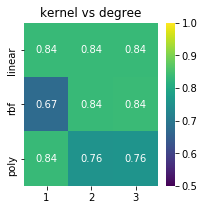

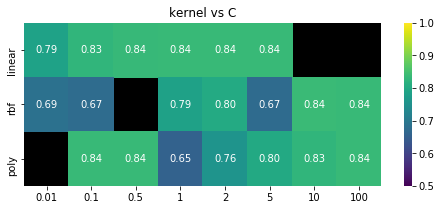

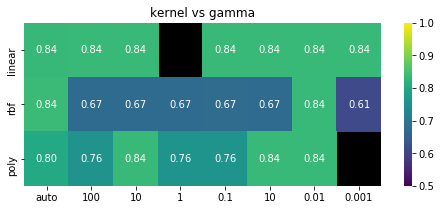

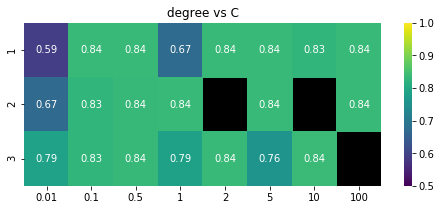

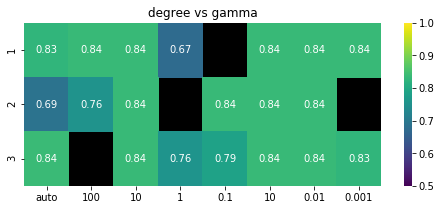

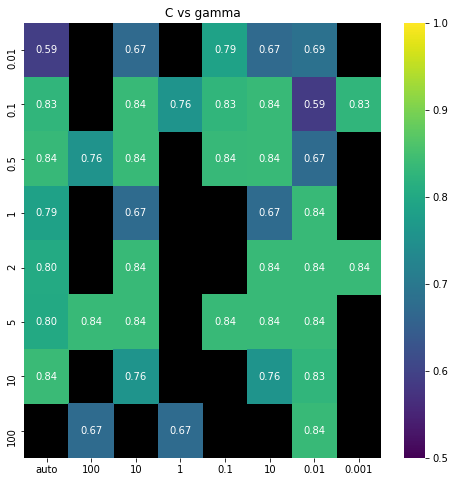

In [17]:
import itertools
import seaborn as sns

listables = []
for key, value in clf.param_distributions.items():
    if isinstance(value, list):
        listables.append(key)

for a, b in itertools.combinations(listables, 2):
#     print(a,b)
    params_a = clf.param_distributions[a]
    params_b = clf.param_distributions[b]
    
    results = []
    for val_a, val_b in itertools.product(params_a, params_b):
        crit_a = clf.cv_results_[f'param_{a}'] == val_a
        crit_b = clf.cv_results_[f'param_{b}'] == val_b
        try:
            best = np.max(clf.cv_results_['mean_test_score'][crit_a & acrit_b])
        except ValueError:
            best = np.nan 
        results.append(best)
#         print('\t', val_a, val_b, best)
    results = np.array(results).reshape((len(params_a), len(params_b)))

    plt.figure(figsize=(len(params_b), len(params_a)))
    ax = sns.heatmap(results, xticklabels=params_b, yticklabels=params_a, annot=True, fmt=".2f", vmin=0.5, vmax=1.0, cmap='viridis')
    ax.set_facecolor("black")
    ax.set_title(f"{a} vs {b}")

## Fit the best estimator ##

In [23]:
print(clf.best_params_)
print(clf.best_score_)
best_estimator = clf.estimator.set_params(**clf.best_params_)
best_estimator.fit(X, y, _timeout=100)
print()

print('non-balanced:')
evaluate_model(best_estimator, test_data)
print()

print('balanced:')
idx, y_pred, y_true = evaluate_model(best_estimator, test_data, balanced=True)

{'kernel': 'rbf', 'gamma': 'auto', 'degree': 3, 'C': 10}
0.8392416525212695

non-balanced:
[[8470  476]
 [ 384  670]]
accuracy: 0.914
precision: 0.7706360028557113
recall: 0.7912327432866225
fscore: 0.780388151174668
support: Counter({0: 8946, 1: 1054})

balanced:
[[4702  250]
 [1724 3324]]
accuracy: 0.8026
precision: 0.8308826359618025
recall: 0.8039969763613415
fscore: 0.7987790475288783
support: Counter({1: 5048, 0: 4952})


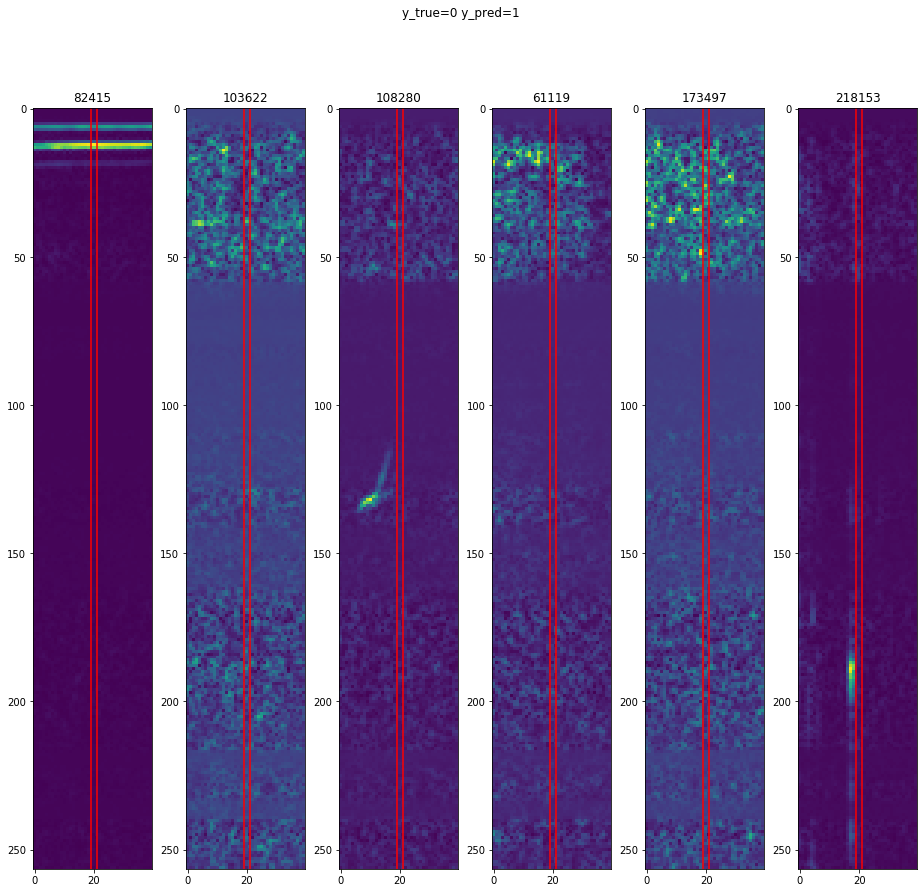

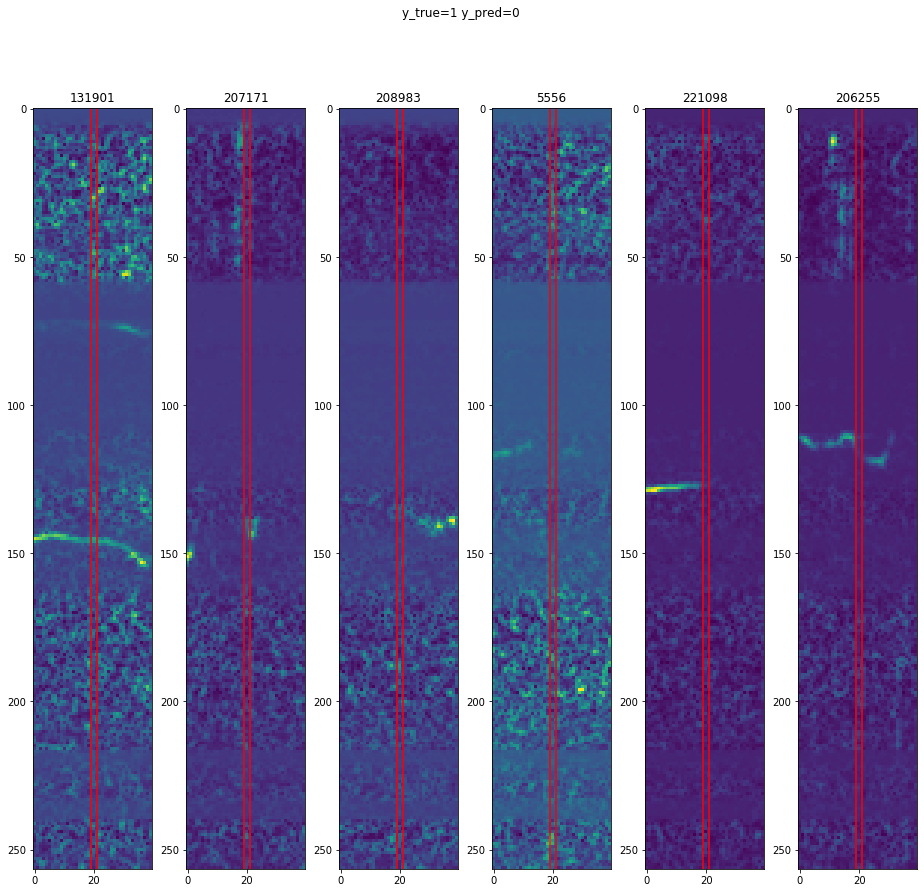

In [38]:
N = 6

################################################
fig, axs = plt.subplots(1, N, figsize=(16, 14))
fig.suptitle('y_true=0 y_pred=1')
for ax, pos in zip(axs, np.random.choice(idx[(y_pred==1) & (y_true == 0)].reshape(-1), N)):
    ax.imshow(test_data.X[pos-20:pos+20].T)
    ax.set_title(f"{pos}")
    ax.axvline(19,color='red')
    ax.axvline(21,color='red')

################################################
fig, axs = plt.subplots(1, N, figsize=(16, 14))
fig.suptitle('y_true=1 y_pred=0')
for ax, pos in zip(axs, np.random.choice(idx[(y_pred==0) & (y_true == 1)].reshape(-1), N)):
    ax.imshow(test_data.X[pos-20:pos+20].T)
    ax.set_title(f"{pos}")
    ax.axvline(19,color='red')
    ax.axvline(21,color='red')


# Generate Selection file #

In [33]:
%time yy = best_estimator.predict(test_data.X)
print(Counter(yy))
print(Counter(test_data.y_binary))
# print(test_data.X.shape)

CPU times: user 3min 14s, sys: 7.38 s, total: 3min 21s
Wall time: 3min 22s
Counter({0: 207512, 1: 26873})
Counter({0: 209553, 1: 24832})


In [36]:
sum(yy == test_data.y_binary) / test_data.y_binary.size

0.9200930093649338

In [78]:
import pandas as pd

def predict_annotations(dataset, y_pred, *, smoothing=0, min_length=0):
    annotations = []
    
    for i, value in enumerate(y_pred):
        if value == 1:
            if len(annotations) and i - annotations[-1][1] - 1 <= smoothing:
                annotations[-1][1] = i
            else:
                annotations.append([i, i])

    annotations = [(a, b) for a, b in annotations if b - a + 1 >= min_length]
    
    return annotations


def create_selection_table(dataset, annotations):
    return pd.DataFrame.from_records([
        (i, 'Spectrogram 1', 1, dataset.frame_to_time(a), dataset.frame_to_time(b), dataset.meta['audio_name']) for i, (a, b) in enumerate(annotations, 1)
    ], columns=[
        'Selection',
        'View',
        'Channel',
        'Begin Time (s)',
        'End Time (s)',
        'Begin Path',
    ], index='Selection')
    
ann = predict_annotations(test_data, yy, smoothing=5, min_length=20)

df = create_annotations_table(test_data, ann)

df.to_csv(test_data.meta['audio_name'].replace('.wav', '.txt'), sep="\t")
df.head(20)

,View,Channel,Begin Time (s),End Time (s),Begin Path
Selection,,,,,
1,Spectrogram 1,1,1.496064,1.527808,ch1-2018-11-20_10-26-36_0000010.wav
2,Spectrogram 1,1,1.618432,1.660416,ch1-2018-11-20_10-26-36_0000010.wav
3,Spectrogram 1,1,2.163200,2.201088,ch1-2018-11-20_10-26-36_0000010.wav
4,Spectrogram 1,1,2.337280,2.372608,ch1-2018-11-20_10-26-36_0000010.wav
5,Spectrogram 1,1,2.895872,2.973696,ch1-2018-11-20_10-26-36_0000010.wav
6,Spectrogram 1,1,3.098112,3.148288,ch1-2018-11-20_10-26-36_0000010.wav
7,Spectrogram 1,1,4.556800,4.575744,ch1-2018-11-20_10-26-36_0000010.wav
8,Spectrogram 1,1,4.856832,4.875776,ch1-2018-11-20_10-26-36_0000010.wav
9,Spectrogram 1,1,6.577664,6.657536,ch1-2018-11-20_10-26-36_0000010.wav


# TODO: Check predictions with LIME #

- https://pbiecek.github.io/PM_VEE/LIME.html
- https://github.com/pbiecek/InterpretableMachineLearning2018S
- biblioteka: https://github.com/marcotcr/lime

# TODO: Random Forest Classifier #

In [17]:
# import sys
# import unittest.mock
# import sklearn
# from sklearn.model_selection import RandomizedSearchCV


# def _fit_and_score(estimator, *args, **kwargs):
#     print('Faking fit')
#     orig_fit_and_score(estimtor, *args, **kwargs)

# class RandomizedSearchCVWithTimeout(RandomizedSearchCV):
#     def __init__(self, estimator, param_distributions, n_iter=10, scoring=None,
#                  n_jobs=None, iid='deprecated', refit=True,
#                  cv=None, verbose=0, pre_dispatch='2*n_jobs',
#                  random_state=None, error_score=np.nan,
#                  return_train_score=False, timeout=None):
#         super().__init__(estimator=estimator, param_distributions=param_distributions, 
#                          n_iter=n_iter, scoring=scoring, n_jobs=n_jobs, iid=iid, refit=refit,
#                          cv=cv, verbose=verbose, pre_dispatch=pre_dispatch,
#                          random_state=random_state, error_score=error_score,
#                          return_train_score=return_train_score)
        
#         self._timeout = timeout
#     def fit(self, *args, **kwargs):
#         orig_fit_and_score = sklearn.model_selection._validation._fit_and_score
        
#         def timeouted_fit(estimator):
#             orig = estimator.fit
#             return orig
        
#         def _fit_and_score(estimator, *args, **kwargs):
#             print('Faking fit')
#             orig_fit_and_score(estimtor, *args, **kwargs)
# #             with unittest.mock.patch(estimator.fit, timeouted_fit(estimator)):
# #                 orig_fit_and_score(estimator, *args, **kwargs)
        
        
#         with unittest.mock.patch('sklearn.model_selection._validation._fit_and_score', _fit_and_score):
#             super().fit(*args, **kwargs)
            
            
# # #     @property
# # #     def verbose(self):
# # #         frame = sys._getframe(1)
# # #         print(dir(frame))
# # #         if str(frame.f_code.co_filename).endswith('sklearn/model_selection/_search.py'):
# # #             print('-'*20, frame.f_lineno)
# # #             print(frame.f_code.co_filename)
# # #             print('>>', frame.f_locals.keys())
# # # #         print(sys._getframe(1).f_code.co_filename)
# # # #         print('*'*100)
# # #         return self._verbose
# # #     @verbose.setter
# # #     def verbose(self, value):
# # #         self._verbose = value
    
# # #     def _run_search(self, evaluate_candidates):
# # #         print('run_search')
# # #         raise RuntimeError()
        
# # print(RandomizedSearchCVWithTimeout.mro())

In [1]:
# from sklearn.ensemble import RandomForestClassifier

# parameters = {
#     'n_estimators': [100, 500, 1000],
#     'max_depth': [20, 40, 100],
# }

# rf = RandomForestClassifier(random_state=0)

# clf = GridSearchCV(rf, parameters, cv=5, verbose=10)

# clf.fit(X, y_binary)

# # clf.cv_results_
# print(clf.best_params_, clf.best_score_)

In [3]:
# print(clf.best_params_, clf.best_score_)

In [2]:
# idx, y_pred, y_true = evaluate_model(rf, train_data)

## Jak oceniać modele? jaka miara? ##
## Jak normalizować dane? potrzebne dla SVMa ##